# Fractals and Chaos

In [27]:
# Settings and imports.
%matplotlib inline
import ast
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Chaos Game

TODO: various improvements

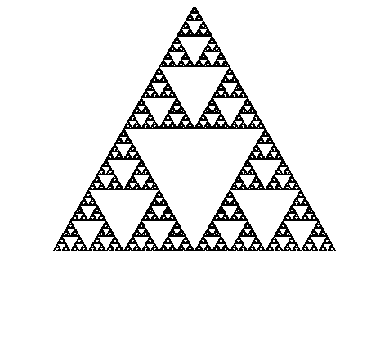

In [3]:
BLACK = (0, 0, 0)

def chaos_game(n_vertices=3, r=0.5, drop_first=100,
               size=400, n_iter=int(1e6)):
    im = Image.new('RGB', (size, size), color='white')
    angles = [
        radians(90 + i * 360/n_vertices)
        for i in range(n_vertices)]
    vertices = [
        (size/2 + cos(angle)*size/2, size/2 + sin(angle)*size/2)
        for angle in angles]
    x, y = random() * size, random() * size
    for i in range(n_iter):
        vertex = choice(vertices)
        x = x * r + vertex[0] * (1-r)
        y = y * r + vertex[1] * (1-r)
        if i > drop_first:
            im.putpixel((int(x), int(y)), BLACK)
    return im

im = chaos_game(n_vertices=3, r=0.5)
show_image(im, flipy=True)

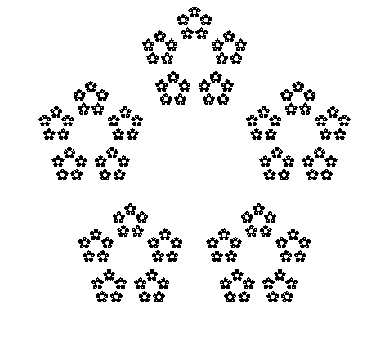

In [4]:
im = chaos_game(n_vertices=5, r=1/3)
show_image(im, flipy=True)

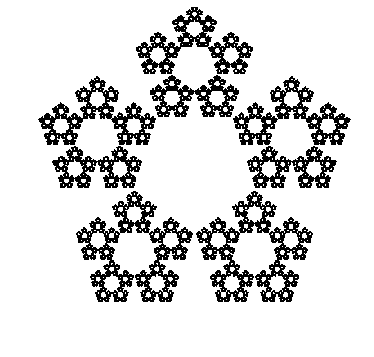

In [5]:
im = chaos_game(n_vertices=5, r=3/8)
show_image(im, flipy=True)

-----

# B) Feigenbaum Diagram

TODO: make it look better in the notebook

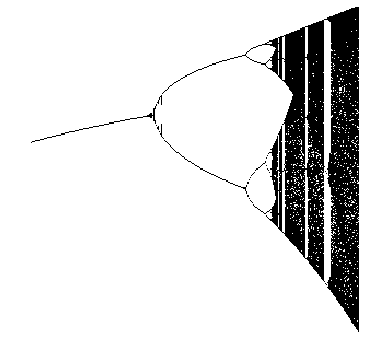

In [44]:
def feigenbaum(r_min=0.6, r_max=1.0, x_min=0, x_max=1,
               size=300, drop_first=100, n_iter=1000):
    im = Image.new('RGB', (size, size), color='white')
    r_step = (r_max - r_min) / size
    rs = [r_min + r_step*i for i in range(size)]
    x_step = (x_max - x_min) / size
    xs = [x_min + x_step*i for i in range(size)]
    for ix, r in enumerate(rs):
        x = x_min + random() * (x_max - x_min)
        for i_iter in range(n_iter):
            x = 4 * r * x * (1 - x)
            if i_iter > drop_first:
                iy = int(size * (x - x_min) / (x_max - x_min))
                im.putpixel((ix, iy), BLACK)
    return im

im = feigenbaum()
show_image(im, flipy=True)
im.save('feigenbaum.png')

-----

# C) L-Systems

TODO:
- allow to set linewidth base on stack depth
- more fractals, experiments with own rules
- inspiration in the referenced book
- refactoring + easier description of interpretation?
  (then factor out LSystem to drawing.py)


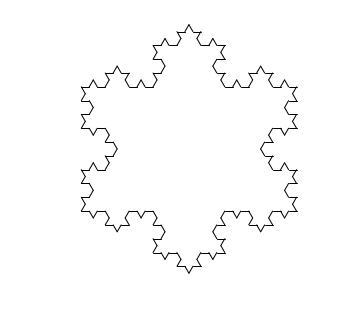

In [52]:
class LSystem:
    def __init__(self, axiom, rules, interpretation):
        self.axiom = axiom
        self.rules = remove_spaces(rules)
        self.interpretation = interpretation
        self.turtle = None
        self.stack = None
    
    def generate_description(self, n):
        description = self.axiom
        for i in range(n):
            description = ''.join([self.expand(c) for c in description])
        return description
    
    def expand(self, char):
        rules = [rule for rule in self.rules if rule[0] == char]
        if not rules:
            return char
        # Currently assumes unique rules.
        rule = rules[0]
        return rule[1]
    
    def interpret(self, char):
        assert self.turtle is not None
        if char == '[':  # push
            self.stack.append(self.turtle.state)
        elif char == ']':  # pop
            self.turtle.state = self.stack.pop()
        elif char in self.interpretation:
            action = self.interpretation[char]
            self.perform_action(action)
            #eval('self.turtle.' + action)
            
    def perform_action(self, action):
        # TODO: Refactor
        action_parts = action.split('(', 1)
        action_name = action_parts[0]
        arg = ast.literal_eval(action_parts[1][:-1])
        if action_name == 'forward':
            depth = len(self.stack)
            color = self.colors[depth]
            self.turtle.forward(arg, color=color)
        elif action_name == 'left':
            self.turtle.left(arg)
        elif action_name == 'right':
            self.turtle.right(arg)            
        
    def draw(self, n=3, angle=0,
             start_color=(0, 0, 0), end_color=(0, 0, 0)):
        description = self.generate_description(n)
        self.stack = []
        self.turtle = Turtle(angle=angle)
        max_depth = find_depth(description)
        if max_depth > 0:
            self.colors = [
                interpolate_color(start_color, end_color, d/max_depth)
                for d in reversed(range(max_depth+1))]
        else:
            self.colors = [start_color]
        for char in description:
            self.interpret(char)
        self.turtle.show()

def remove_spaces(rules):
    spacefree_rules = [
        (left, right.replace(' ', ''))
        for (left, right) in rules]
    return spacefree_rules

def interpolate_color(first, second, ratio):
    return tuple(ratio*f + (1-ratio)*s for f, s in zip(first, second))

def find_depth(description):
    depth = 0
    max_depth = 0
    for c in description:
        if c == '[':
            depth += 1
        if c == ']':
            depth -= 1
        max_depth = max(depth, max_depth)
    return max_depth

interpretation = {
    'F': 'forward(10)',
    '-': 'left(60)',
    '+': 'right(60)'}
koch = LSystem('F--F--F', [('F', 'F+F--F+F')], interpretation)
koch.draw(n=3)

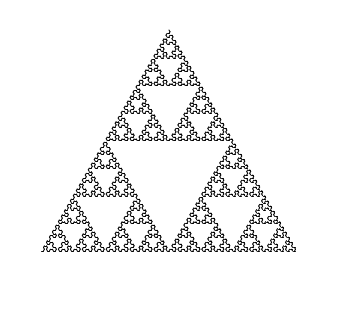

In [24]:
sierpinski = LSystem(
    'A',
    [('A', 'B-A-B'), ('B', 'A+B+A')],
    {'A': 'forward(10)',
     'B': 'forward(10)',
     '-': 'left(60)',
     '+': 'right(60)'})
sierpinski.draw(n=7)

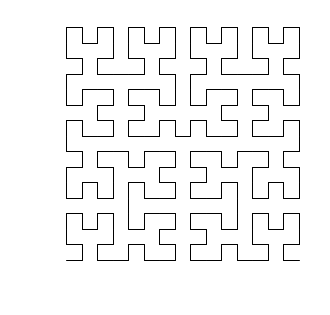

In [18]:
hilbert = LSystem(
    'A',
    [('A', '-BF+AFA+FB-'),
     ('B', '+AF-BFB-FA+')],
    {'F': 'forward(10)',
     '-': 'left(90)',
     '+': 'right(90)'})
hilbert.draw(n=4)

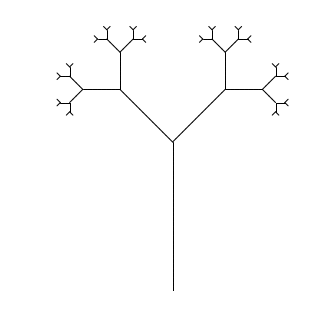

In [59]:
tree = LSystem(
    'A',
    [('A', 'F[+A]-A'), ('F', 'FF')],
    {'F': 'forward(10)',
     '-': 'left(45)',
     '+': 'right(45)'})
tree.draw(n=6, angle=90)

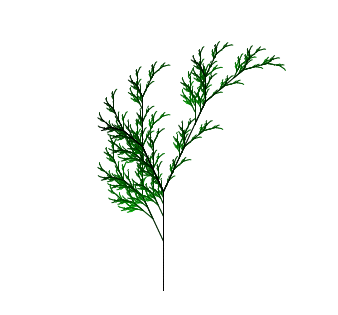

In [57]:
tree = LSystem(
    'A',
    [('A', 'F - [ [ A ] + A ] + F [ + F A ] - A'),
     ('F', 'F F')],
    {'F': 'forward(10)',
     '-': 'left(25)',
     '+': 'right(25)'})
tree.draw(n=6, angle=90, end_color=(0, 0.8, 0))

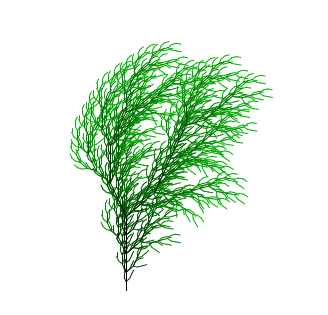

In [60]:
bush = LSystem(
    'F',
    [('F', 'FF+[+F-FF]-[-F+F+F]')],
    {'F': 'forward(10)',
     '-': 'left(25)',
     '+': 'right(25)'})
bush.draw(n=4, angle=90, end_color=(0, 0.7, 0))